In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from venn import venn
import plotly.express as px
import shap
import matplotlib.pyplot as plt
from collections import defaultdict

In [303]:
pd.options.display.max_columns = 50
# mpl.rcParams['font.family'] = 'Avenir'
plt.rc('font', family='Helvetica')
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.figsize'] = (10.0, 7.0)

# protein

In [4]:
df_rf = pd.read_csv("../../work_dirs/protein/RandomForest/feature_importance_202006051013_ruv_min_300.csv")
df_en = pd.read_csv("../../work_dirs/protein/ElasticNet/feature_importance_202006061215_ruv_min_300.csv")
df_shap = pd.read_csv("../../result_files/shap/test_70_202006082240.csv")

# RNA

In [8]:
df = pd.read_csv("../work_dirs/rna_common_norm/RandomForest/feature_importance_202004081135_rna_300.csv")

In [9]:
drug = '438'

In [10]:
df[['rna_common', f'importance_{drug}']].sort_values(by=[f'importance_{drug}'], ascending=False).head(30)

,rna_common,importance_438
1178,GPX8,0.004540
1139,GNG12,0.004407
413,CCN1,0.004274
2625,S100A6,0.003820
1400,ITGB1,0.003735
1483,LAMB2,0.003703
2196,PPIC,0.003291
987,FAM114A1,0.003199
2623,S100A2,0.003040
657,CTSL,0.002985


# Tissue type shap

## compute

In [12]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import ElasticNet
from lightgbm import LGBMClassifier

In [14]:
config_file = '../../configs/cancer_type/lgbm_grid_search_tissuetype.json'
configs = json.load(open(config_file, 'r'))

In [16]:
seed = configs['seed']
cv = StratifiedKFold(n_splits=configs['cv'], shuffle=True, random_state=seed)

data_sample = pd.read_csv('../../data/cancer_type/cancer_tissue_type_protein.tsv', sep='\t')

data_sample = data_sample.drop(['Cell_line'], axis=1)

type_count = data_sample.groupby([configs['target']]).size()
selected_types = type_count[type_count > configs['cut_off']].index.values
data_sample = data_sample[data_sample[configs['target']].isin(selected_types)].reset_index(drop=True)
proteins = np.array([x for x in data_sample.columns if '_HUMAN' in x])
X = data_sample[proteins]
y = data_sample[configs['target']]
imputer = None
if configs['imputer'] == 'mean':
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
elif configs['imputer'] == 'KNN':
    imputer = KNNImputer(missing_values=np.nan)
elif configs['imputer'] == 'zero':
    imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
elif configs['imputer'] == 'min':
    imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=configs['min_val'])

if imputer:
    X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=seed, shuffle=True,
                                                    test_size=0.2)

In [20]:
params = {'max_bin': 500, 'n_estimators': 700, 'num_leaves': 21, 'n_jobs': -1}
clf = LGBMClassifier(**params)

In [16]:
clf.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_bin=500,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=700, n_jobs=-1, num_leaves=21,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [17]:
explainer = shap.TreeExplainer(clf)
lgbm_shap_values = explainer.shap_values(X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [253]:
# pickle.dump(lgbm_shap_values, open("../work_dirs/shap_tissue/lgbm_shap_values_tissue_14.pkl", "wb"))

In [10]:
lgbm_shap_values = pickle.load(open("../../work_dirs/shap_tissue/lgbm_shap_values_tissue_14.pkl", "rb"))

In [17]:
topN = 10
shap_tissue_set = []
for tissue_shap in lgbm_shap_values:
    shap_top_proteins = proteins[np.argsort(-np.mean(np.abs(tissue_shap),axis=0))][:topN]
    shap_tissue_set.extend([f"{x}" for x in shap_top_proteins])
shap_tissue_set = set(shap_tissue_set)

## load set

In [19]:
pickle.dump(shap_tissue_set, open("../../work_dirs/shap_tissue/shap_tissue_set.pkl", "wb"))

In [ ]:
shap_tissue_set = pickle.load(open("../../work_dirs/shap_tissue/shap_tissue_set.pkl", "rb"))

# rf vs en vs shap

## rank vs count excluding tissue

In [262]:
df_rf = pd.read_csv("../../work_dirs/protein/RandomForest/feature_importance_202006051013_ruv_min_300.csv")
df_en = pd.read_csv("../../work_dirs/protein/ElasticNet/feature_importance_202006061215_ruv_min_300.csv")
df_shap = pd.read_csv("../../result_files/shap/test_70_202006111046.csv")

In [263]:
drug_list = [1909, 1114, 1373, 1919, 1377, 119, 427, 1910, 1047]
drug_score = pd.read_csv("../../data/drug/final_drug_scores.tsv", sep="\t")
drug_list = drug_score[
    (drug_score['MultiDrug_correlation'] > 0.4) & (drug_score['sensitive_count'] > 20)][
    'drug_id'].values

In [264]:
drug_name_map = drug_score[[
    'drug_id', 'drug_name'
]].drop_duplicates().set_index('drug_id').to_dict()['drug_name']
drug_target_map = drug_score[[
    'drug_id', 'putative_gene_target'
]].drop_duplicates().set_index('drug_id').to_dict()['putative_gene_target']

### rf

In [265]:
topN = 50
rf_dict_count = {}
rf_dict_rank = {}
rf_dict_drug = {}
for drug in drug_list:
    rf_top_proteins = df_rf[['protein', f'importance_{drug}'
           ]].sort_values(by=[f'importance_{drug}'],
                          ascending=False).head(topN)['protein'].values
    rf_top_proteins = [x for x in rf_top_proteins if x not in shap_tissue_set]
    for i in range(len(rf_top_proteins)):
        if rf_top_proteins[i] not in rf_dict_count:
            rf_dict_count[rf_top_proteins[i]] = 0
            rf_dict_rank[rf_top_proteins[i]] = []
            rf_dict_drug[rf_top_proteins[i]] = []
            
        rf_dict_rank[rf_top_proteins[i]].append(i)
        rf_dict_count[rf_top_proteins[i]] += 1
        rf_dict_drug[rf_top_proteins[i]].append(drug)

In [266]:
rf_df = {'protein':[], f'{topN}-avg_rank':[], 'count':[]}
for p in rf_dict_rank:
    rf_dict_rank[p] = topN - np.average(rf_dict_rank[p])
    rf_df['protein'].append(p)
    rf_df[f'{topN}-avg_rank'].append(rf_dict_rank[p])
    rf_df['count'].append(rf_dict_count[p])
rf_df = pd.DataFrame(rf_df)

In [267]:
rf_df_filtered = rf_df[rf_df['count']+rf_df[f'{topN}-avg_rank'] > topN]

In [268]:
rf_df_filtered['category'] = rf_df_filtered.apply(
    lambda row: 'drug specific' if (row[f'{topN}-avg_rank'] > 48 and row['count'] < 50) 
    else 'pan-drug'
    if row['count'] > 200 else 'other', axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


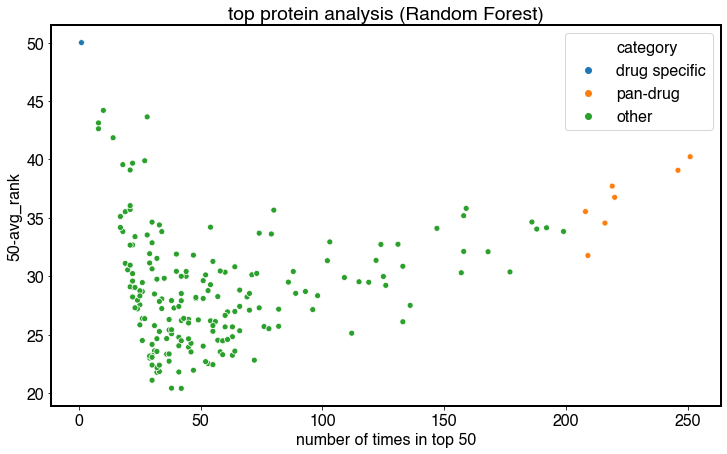

In [269]:
plt.figure(figsize=(12, 7))
g = sns.scatterplot(x='count',
                    y=f'{topN}-avg_rank',
                    hue='category',
                    hue_order=['drug specific', 'pan-drug', 'other'],
                    data=rf_df_filtered)
# for index, row in rf_df_filtered.iterrows():
#     if row['category'] != 'other':
#         g.annotate(row['protein'],
#                    xy=(row['count'], row[f'{topN}-avg_rank']),
#                    xycoords='data',
#                    xytext=(0, 20),
#                    textcoords='offset points',
#                    arrowprops=dict(arrowstyle="->"))
plt.xlabel(f'number of times in top {topN}')
plt.title("top protein analysis (Random Forest)")
plt.show()

In [270]:
rf_df_filtered[rf_df_filtered['category']!='other'].sort_values([f'{topN}-avg_rank'], ascending=False)

,protein,50-avg_rank,count,category
259,NXN_HUMAN,50.000000,1,drug specific
1459,ARGL1_HUMAN,50.000000,1,drug specific
329,LMNA_HUMAN,40.235060,251,pan-drug
333,GBG12_HUMAN,39.073171,246,pan-drug
721,NCEH1_HUMAN,37.716895,219,pan-drug
785,ITPI2_HUMAN,36.759091,220,pan-drug
760,ANXA2_HUMAN,35.538462,208,pan-drug
711,TMED1_HUMAN,34.555556,216,pan-drug
15,CTND1_HUMAN,31.775120,209,pan-drug


### ENet

In [271]:
topN = 50
en_dict_count = {}
en_dict_rank = {}
en_dict_drug = {}
for drug in drug_list:
    tmp = df_en[['protein', f'importance_{drug}']]
    tmp = tmp[tmp[f'importance_{drug}'] != 0]
    tmp['abs'] = np.abs(tmp[f'importance_{drug}'])
    en_top_proteins = tmp.sort_values(by=['abs'],
                        ascending=False)[['protein', f'importance_{drug}'
                                          ]].head(topN)['protein'].values
    en_top_proteins = [x for x in en_top_proteins if x not in shap_tissue_set]
    for i in range(len(en_top_proteins)):
        if en_top_proteins[i] not in en_dict_count:
            en_dict_count[en_top_proteins[i]] = 0
            en_dict_rank[en_top_proteins[i]] = []
            en_dict_drug[en_top_proteins[i]] = []
            
        en_dict_rank[en_top_proteins[i]].append(i)
        en_dict_count[en_top_proteins[i]] += 1
        en_dict_drug[en_top_proteins[i]].append(drug)

In [272]:
en_df = {'protein':[], f'{topN}-avg_rank':[], 'count':[]}
for p in en_dict_rank:
    en_dict_rank[p] = topN - np.average(en_dict_rank[p])
    en_df['protein'].append(p)
    en_df[f'{topN}-avg_rank'].append(en_dict_rank[p])
    en_df['count'].append(en_dict_count[p])
en_df = pd.DataFrame(en_df)

In [273]:
en_df_filtered = en_df[en_df['count']+en_df[f'{topN}-avg_rank'] > topN]

In [274]:
en_df_filtered['category'] = en_df_filtered.apply(
    lambda row: 'drug specific'
    if (row[f'{topN}-avg_rank'] > topN-2 and row['count'] < 100) 
    else 'pan-drug'if (row['count'] > 100 and row[f'{topN}-avg_rank'] > 10)
    else 'other',
    axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'top protein analysis (Elastic Net)')

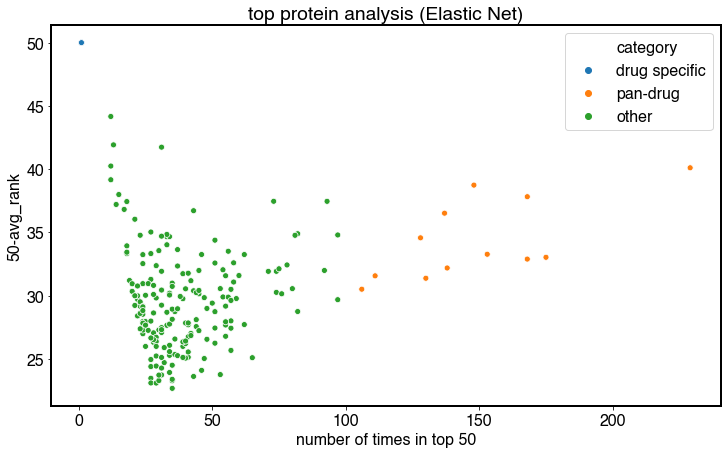

In [275]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x='count',
                y=f'{topN}-avg_rank',
                hue='category',
                hue_order=['drug specific', 'pan-drug', 'other'],
                data=en_df_filtered)
plt.xlabel(f'number of times in top {topN}')
plt.title("top protein analysis (Elastic Net)")

In [276]:
en_df_filtered[en_df_filtered['category']!='other'].sort_values([f'{topN}-avg_rank'], ascending=False)

,protein,50-avg_rank,count,category
1064,C43BP_HUMAN,50.000000,1,drug specific
1138,COMT_HUMAN,50.000000,1,drug specific
1211,ADK_HUMAN,50.000000,1,drug specific
427,B2CL1_HUMAN,40.113537,229,pan-drug
184,LMNA_HUMAN,38.743243,148,pan-drug
535,SQSTM_HUMAN,37.827381,168,pan-drug
173,ELF1_HUMAN,36.525547,137,pan-drug
107,BAD_HUMAN,34.578125,128,pan-drug
255,SVIP_HUMAN,33.281046,153,pan-drug
143,K1C18_HUMAN,33.040000,175,pan-drug


In [277]:
en_df[en_df['protein'].isin([
    'ERBB2_HUMAN', 'MIEN1_HUMAN', 'LMNA_HUMAN', 'K2C8_HUMAN', 'LSP1_HUMAN',
    'ANXA2_HUMAN', 'ABCF2_HUMAN', 'TMM33_HUMAN', 'TIMP1_HUMAN', 'NAMPT_HUMAN',
    'NNRD_HUMAN'
])]

,protein,50-avg_rank,count
184,LMNA_HUMAN,38.743243,148
466,K2C8_HUMAN,32.898810,168
567,TMM33_HUMAN,27.526316,19
794,NNRD_HUMAN,31.190476,42
819,ANXA2_HUMAN,30.157895,76
867,NAMPT_HUMAN,29.937500,16
944,TIMP1_HUMAN,35.800000,5
950,MIEN1_HUMAN,34.709677,31
1087,LSP1_HUMAN,24.700000,10
1329,ERBB2_HUMAN,41.923077,13


### shap

In [278]:
topN = 50
shap_dict_count = {}
shap_dict_rank = {}
shap_dict_drug = {}
for drug in drug_list:
    tmp = df_shap[['protein', f'importance_{drug}']]
    tmp = tmp[tmp[f'importance_{drug}'] != 0]
    tmp['abs'] = np.abs(tmp[f'importance_{drug}'])
    shap_top_proteins = tmp.sort_values(by=['abs'],
                        ascending=False)[['protein', f'importance_{drug}'
                                          ]].head(topN)['protein'].values
    shap_top_proteins = [x for x in shap_top_proteins if x not in shap_tissue_set]
    for i in range(len(shap_top_proteins)):
        if shap_top_proteins[i] not in shap_dict_count:
            shap_dict_count[shap_top_proteins[i]] = 0
            shap_dict_rank[shap_top_proteins[i]] = []
            shap_dict_drug[shap_top_proteins[i]] = []
            
        shap_dict_rank[shap_top_proteins[i]].append(i)
        shap_dict_count[shap_top_proteins[i]] += 1
        shap_dict_drug[shap_top_proteins[i]].append(drug)

In [279]:
shap_df = {'protein':[], f'{topN}-avg_rank':[], 'count':[]}
for p in shap_dict_rank:
    shap_dict_rank[p] = topN - np.average(shap_dict_rank[p])
    shap_df['protein'].append(p)
    shap_df[f'{topN}-avg_rank'].append(shap_dict_rank[p])
    shap_df['count'].append(shap_dict_count[p])
shap_df = pd.DataFrame(shap_df)

In [280]:
shap_df_filtered = shap_df[shap_df['count']+shap_df[f'{topN}-avg_rank'] > (topN-10)]

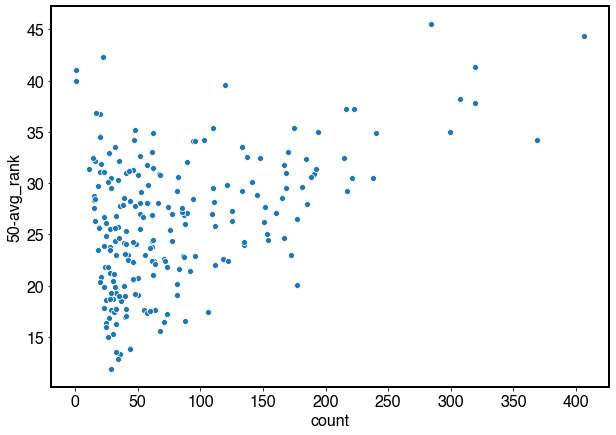

In [281]:
sns.scatterplot(x='count', y=f'{topN}-avg_rank', data=shap_df_filtered)

In [282]:
shap_df_filtered['category'] = shap_df_filtered.apply(
    lambda row: 'drug specific' if (row[f'{topN}-avg_rank'] >= 40 and row['count'] < 50) 
    else 'pan-drug'
    if row['count'] > 200 else 'other', axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'top protein analysis (MultiDrugNN)')

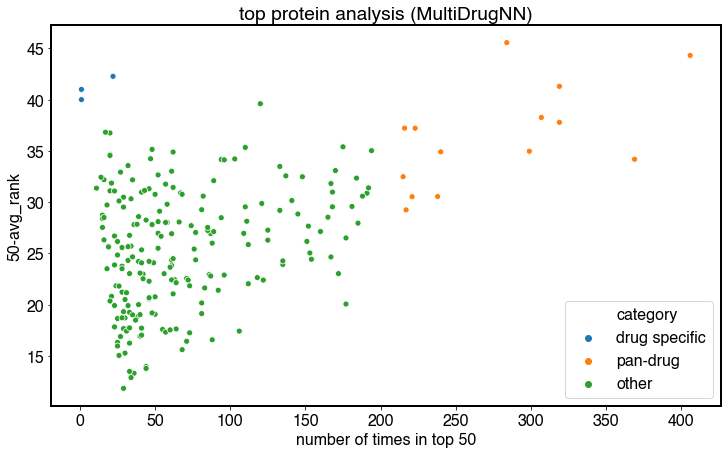

In [283]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x='count',
                y=f'{topN}-avg_rank',
                hue='category',
                hue_order=['drug specific', 'pan-drug', 'other'],
                data=shap_df_filtered)
plt.xlabel(f'number of times in top {topN}')
plt.title("top protein analysis (MultiDrugNN)")

In [284]:
shap_df_filtered[shap_df_filtered['category']!='other'].sort_values([f'{topN}-avg_rank'], ascending=False)

,protein,50-avg_rank,count,category
198,PYGB_HUMAN,45.563380,284,pan-drug
4,41_HUMAN,44.312808,406,pan-drug
118,ETHE1_HUMAN,42.272727,22,drug specific
49,CAN2_HUMAN,41.297806,319,pan-drug
433,MYPT1_HUMAN,41.000000,1,drug specific
434,FAH2A_HUMAN,40.000000,1,drug specific
58,PTMA_HUMAN,38.257329,307,pan-drug
24,CD97_HUMAN,37.786834,319,pan-drug
48,SCG2_HUMAN,37.222222,216,pan-drug
55,K1C14_HUMAN,37.210762,223,pan-drug


### combined

In [285]:
tmp = pd.merge(rf_df_filtered, en_df_filtered, on=['protein'], suffixes=['_rf', '_en'])

In [286]:
tmp = pd.merge(tmp, shap_df_filtered, on=['protein'])

In [287]:
tmp['count_avg'] = tmp.apply(
    lambda row: np.average([row['count'], row['count_en'], row['count_rf']]), axis=1)
tmp['rank_score_avg'] = tmp.apply(lambda row: np.average([
    row['50-avg_rank'], row['50-avg_rank_en'], row['50-avg_rank_rf']]), axis=1)

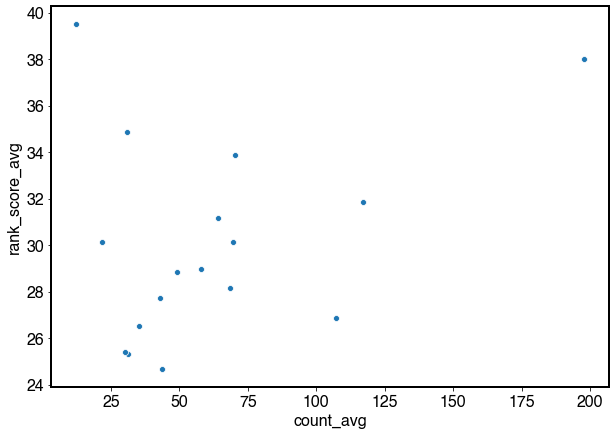

In [288]:
sns.scatterplot(x='count_avg', y='rank_score_avg', data=tmp)

In [289]:
tmp['category_avg'] = tmp.apply(
    lambda row: 'drug-specific' if (row[f'rank_score_avg'] >= 35 and row['count_avg'] < 20) 
    else 'pan-drug'
    if row['count_avg'] > 150 else 'other', axis=1)

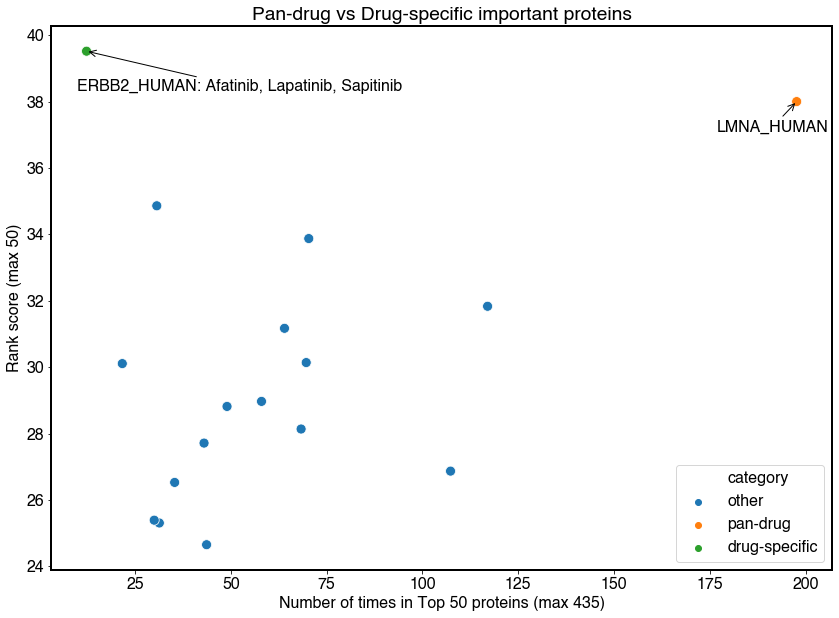

In [304]:
fig = plt.figure(figsize=(14, 10))
ax = sns.scatterplot(x='count_avg', y='rank_score_avg', hue='category_avg', data=tmp, s=100)
plt.xlabel("Number of times in Top 50 proteins (max 435)")
plt.ylabel("Rank score (max 50)")
plt.title("Pan-drug vs Drug-specific important proteins")
handles, labels = ax.get_legend_handles_labels()
labels[0] = 'category'
ax.legend(handles, labels)

ax.annotate('ERBB2_HUMAN: Afatinib, Lapatinib, Sapitinib',
            xy=(12.333333, 39.517216), xycoords='data',
            xytext=(-10, -40), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"), fontsize=16)

ax.annotate('LMNA_HUMAN',
            xy=(197.666667, 37.999641), xycoords='data',
            xytext=(-80, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"), fontsize=16)
# plt.show()
plt.savefig("../../plots/Fig4D.pdf", dpi=500)

In [102]:
tmp[tmp['category_avg']!='other'].sort_values([f'rank_score_avg'], ascending=False)

,protein,50-avg_rank_rf,count_rf,category_rf,50-avg_rank_en,count_en,category_en,50-avg_rank,count,category,count_avg,rank_score_avg,category_avg
16,ERBB2_HUMAN,44.20000,10,other,41.923077,13,other,32.428571,14,other,12.333333,39.517216,drug-specific
6,LMNA_HUMAN,40.23506,251,pan-drug,38.743243,148,pan-drug,35.020619,194,other,197.666667,37.999641,pan-drug


### drug-specific

In [108]:
ERBB2_drugs = set(shap_dict_drug['ERBB2_HUMAN']).intersection(
    set(rf_dict_drug['ERBB2_HUMAN'])).intersection(
        set(en_dict_drug['ERBB2_HUMAN']))

In [109]:
for drug in ERBB2_drugs:
    print(drug_name_map[drug])

Afatinib
CP-724714
Poziotinib
PF-06747775
Ibrutinib
Afatinib
Lapatinib
Osimertinib


In [85]:
for drug in TMM33_drugs:
    print(drug_name_map[drug])

BAM7


## rank vs count excluding tissue - no growth

In [208]:
df_rf = pd.read_csv(
    "../../work_dirs/protein/RandomForest/feature_importance_202006052029_ruv_min_300_growth_corrected.csv"
)
df_en = pd.read_csv(
    "../../work_dirs/protein/ElasticNet/feature_importance_202006071209_ruv_min_300_growth_corrected.csv"
)
df_shap = pd.read_csv("../../result_files/shap/test_25_202006111047_growth_corrected.csv")

In [209]:
drug_list = [1909, 1114, 1373, 1919, 1377, 119, 427, 1910, 1047]
drug_score = pd.read_csv("../../data/drug/final_drug_scores.tsv", sep="\t")
drug_list = drug_score[
    (drug_score['MultiDrug_correlation'] > 0.4) & (drug_score['sensitive_count'] > 20)][
    'drug_id'].values

In [210]:
drug_name_map = drug_score[[
    'drug_id', 'drug_name'
]].drop_duplicates().set_index('drug_id').to_dict()['drug_name']
drug_target_map = drug_score[[
    'drug_id', 'putative_gene_target'
]].drop_duplicates().set_index('drug_id').to_dict()['putative_gene_target']

### rf

In [211]:
topN = 50
rf_dict_count = {}
rf_dict_rank = {}
rf_dict_drug = {}
for drug in drug_list:
    rf_top_proteins = df_rf[['protein', f'importance_{drug}'
           ]].sort_values(by=[f'importance_{drug}'],
                          ascending=False).head(topN)['protein'].values
    rf_top_proteins = [x for x in rf_top_proteins if x not in shap_tissue_set]
    for i in range(len(rf_top_proteins)):
        if rf_top_proteins[i] not in rf_dict_count:
            rf_dict_count[rf_top_proteins[i]] = 0
            rf_dict_rank[rf_top_proteins[i]] = []
            rf_dict_drug[rf_top_proteins[i]] = []
            
        rf_dict_rank[rf_top_proteins[i]].append(i)
        rf_dict_count[rf_top_proteins[i]] += 1
        rf_dict_drug[rf_top_proteins[i]].append(drug)

In [212]:
rf_df = {'protein':[], f'{topN}-avg_rank':[], 'count':[]}
for p in rf_dict_rank:
    rf_dict_rank[p] = topN - np.average(rf_dict_rank[p])
    rf_df['protein'].append(p)
    rf_df[f'{topN}-avg_rank'].append(rf_dict_rank[p])
    rf_df['count'].append(rf_dict_count[p])
rf_df = pd.DataFrame(rf_df)

In [213]:
rf_df_filtered = rf_df[rf_df['count']+rf_df[f'{topN}-avg_rank'] > topN]

In [214]:
rf_df_filtered['category'] = rf_df_filtered.apply(
    lambda row: 'drug specific' if (row[f'{topN}-avg_rank'] > 48 and row['count'] < 50) 
    else 'pan-drug'
    if row['count'] > 200 else 'other', axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


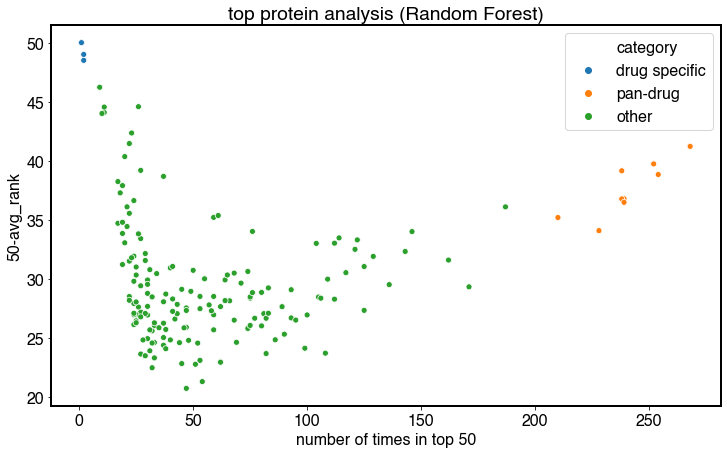

In [215]:
plt.figure(figsize=(12, 7))
g = sns.scatterplot(x='count',
                    y=f'{topN}-avg_rank',
                    hue='category',
                    hue_order=['drug specific', 'pan-drug', 'other'],
                    data=rf_df_filtered)
# for index, row in rf_df_filtered.iterrows():
#     if row['category'] != 'other':
#         g.annotate(row['protein'],
#                    xy=(row['count'], row[f'{topN}-avg_rank']),
#                    xycoords='data',
#                    xytext=(0, 20),
#                    textcoords='offset points',
#                    arrowprops=dict(arrowstyle="->"))
plt.xlabel(f'number of times in top {topN}')
plt.title("top protein analysis (Random Forest)")
plt.show()

In [216]:
rf_df_filtered[rf_df_filtered['category']!='other'].sort_values([f'{topN}-avg_rank'], ascending=False)

,protein,50-avg_rank,count,category
1301,ADK_HUMAN,50.000000,1,drug specific
1878,TMX4_HUMAN,50.000000,1,drug specific
1966,EP15R_HUMAN,50.000000,1,drug specific
2034,IPYR2_HUMAN,50.000000,1,drug specific
1419,REXO4_HUMAN,49.000000,2,drug specific
1949,HCLS1_HUMAN,48.500000,2,drug specific
364,GBG12_HUMAN,41.212687,268,pan-drug
360,LMNA_HUMAN,39.730159,252,pan-drug
757,ITPI2_HUMAN,39.147059,238,pan-drug
440,NCEH1_HUMAN,38.830709,254,pan-drug


### ENet

In [217]:
topN = 50
en_dict_count = {}
en_dict_rank = {}
en_dict_drug = {}
for drug in drug_list:
    tmp = df_en[['protein', f'importance_{drug}']]
    tmp = tmp[tmp[f'importance_{drug}'] != 0]
    tmp['abs'] = np.abs(tmp[f'importance_{drug}'])
    en_top_proteins = tmp.sort_values(by=['abs'],
                        ascending=False)[['protein', f'importance_{drug}'
                                          ]].head(topN)['protein'].values
    en_top_proteins = [x for x in en_top_proteins if x not in shap_tissue_set]
    for i in range(len(en_top_proteins)):
        if en_top_proteins[i] not in en_dict_count:
            en_dict_count[en_top_proteins[i]] = 0
            en_dict_rank[en_top_proteins[i]] = []
            en_dict_drug[en_top_proteins[i]] = []
            
        en_dict_rank[en_top_proteins[i]].append(i)
        en_dict_count[en_top_proteins[i]] += 1
        en_dict_drug[en_top_proteins[i]].append(drug)

In [218]:
en_df = {'protein':[], f'{topN}-avg_rank':[], 'count':[]}
for p in en_dict_rank:
    en_dict_rank[p] = topN - np.average(en_dict_rank[p])
    en_df['protein'].append(p)
    en_df[f'{topN}-avg_rank'].append(en_dict_rank[p])
    en_df['count'].append(en_dict_count[p])
en_df = pd.DataFrame(en_df)

In [219]:
en_df_filtered = en_df[en_df['count']+en_df[f'{topN}-avg_rank'] > topN]

In [220]:
en_df_filtered['category'] = en_df_filtered.apply(
    lambda row: 'drug specific'
    if (row[f'{topN}-avg_rank'] > topN-2 and row['count'] < 100) 
    else 'pan-drug'if (row['count'] > 100 and row[f'{topN}-avg_rank'] > 10)
    else 'other',
    axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'top protein analysis (Elastic Net)')

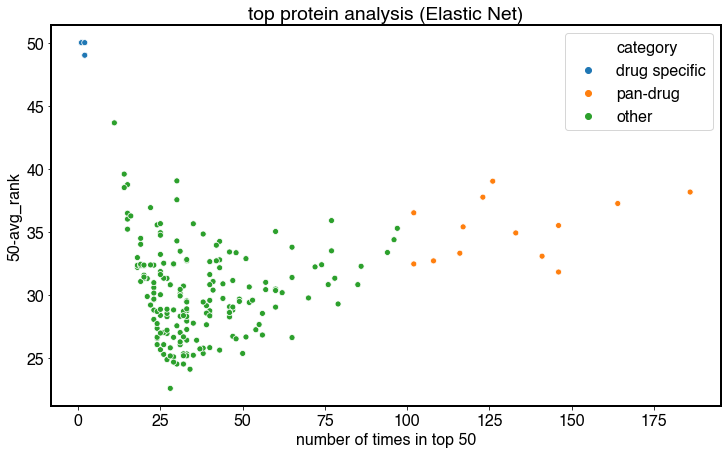

In [221]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x='count',
                y=f'{topN}-avg_rank',
                hue='category',
                hue_order=['drug specific', 'pan-drug', 'other'],
                data=en_df_filtered)
plt.xlabel(f'number of times in top {topN}')
plt.title("top protein analysis (Elastic Net)")

In [222]:
en_df_filtered[en_df_filtered['category']!='other'].sort_values([f'{topN}-avg_rank'], ascending=False)

,protein,50-avg_rank,count,category
1471,PSB5_HUMAN,50.000000,2,drug specific
1082,UBS3B_HUMAN,50.000000,1,drug specific
1460,LIS1_HUMAN,50.000000,1,drug specific
1287,GPC4_HUMAN,50.000000,1,drug specific
1208,ADK_HUMAN,50.000000,1,drug specific
449,TOP2A_HUMAN,50.000000,1,drug specific
1190,K2C6A_HUMAN,49.000000,2,drug specific
1102,CD3E_HUMAN,49.000000,2,drug specific
201,GMFG_HUMAN,39.007937,126,pan-drug
387,B2CL1_HUMAN,38.145161,186,pan-drug


### shap

In [223]:
topN = 50
shap_dict_count = {}
shap_dict_rank = {}
shap_dict_drug = {}
for drug in drug_list:
    tmp = df_shap[['protein', f'importance_{drug}']]
    tmp = tmp[tmp[f'importance_{drug}'] != 0]
    tmp['abs'] = np.abs(tmp[f'importance_{drug}'])
    shap_top_proteins = tmp.sort_values(by=['abs'],
                        ascending=False)[['protein', f'importance_{drug}'
                                          ]].head(topN)['protein'].values
    shap_top_proteins = [x for x in shap_top_proteins if x not in shap_tissue_set]
    for i in range(len(shap_top_proteins)):
        if shap_top_proteins[i] not in shap_dict_count:
            shap_dict_count[shap_top_proteins[i]] = 0
            shap_dict_rank[shap_top_proteins[i]] = []
            shap_dict_drug[shap_top_proteins[i]] = []
            
        shap_dict_rank[shap_top_proteins[i]].append(i)
        shap_dict_count[shap_top_proteins[i]] += 1
        shap_dict_drug[shap_top_proteins[i]].append(drug)

In [224]:
shap_df = {'protein':[], f'{topN}-avg_rank':[], 'count':[]}
for p in shap_dict_rank:
    shap_dict_rank[p] = topN - np.average(shap_dict_rank[p])
    shap_df['protein'].append(p)
    shap_df[f'{topN}-avg_rank'].append(shap_dict_rank[p])
    shap_df['count'].append(shap_dict_count[p])
shap_df = pd.DataFrame(shap_df)

In [225]:
shap_df_filtered = shap_df[shap_df['count']+shap_df[f'{topN}-avg_rank'] > (topN-10)]

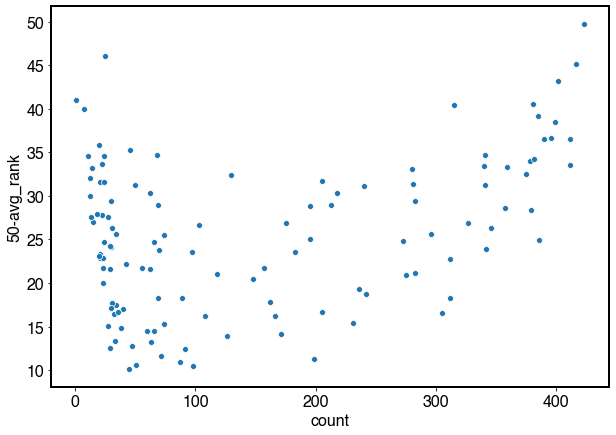

In [226]:
sns.scatterplot(x='count', y=f'{topN}-avg_rank', data=shap_df_filtered)

In [227]:
shap_df_filtered['category'] = shap_df_filtered.apply(
    lambda row: 'drug specific' if (row[f'{topN}-avg_rank'] >= 40 and row['count'] < 50) 
    else 'pan-drug'
    if row['count'] > 350 else 'other', axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'top protein analysis (MultiDrugNN)')

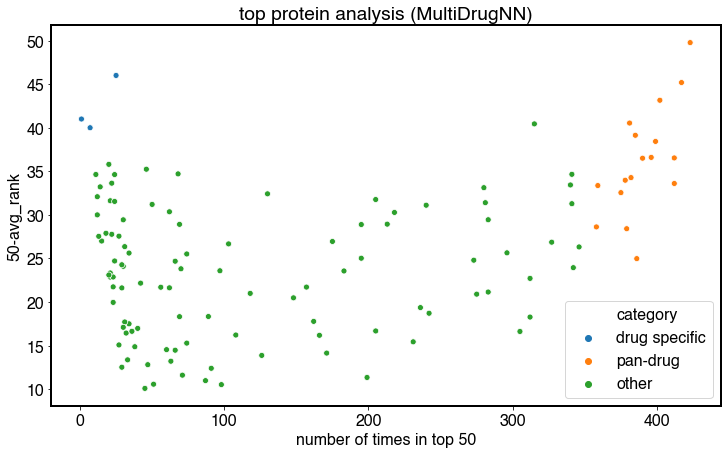

In [228]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x='count',
                y=f'{topN}-avg_rank',
                hue='category',
                hue_order=['drug specific', 'pan-drug', 'other'],
                data=shap_df_filtered)
plt.xlabel(f'number of times in top {topN}')
plt.title("top protein analysis (MultiDrugNN)")

In [229]:
shap_df_filtered[shap_df_filtered['category']!='other'].sort_values([f'{topN}-avg_rank'], ascending=False)

,protein,50-avg_rank,count,category
1,K2C7_HUMAN,49.768322,423,pan-drug
88,GSTO1_HUMAN,46.000000,25,drug specific
22,PARP4_HUMAN,45.187050,417,pan-drug
41,SCG2_HUMAN,43.151741,402,pan-drug
249,FSCN1_HUMAN,41.000000,1,drug specific
46,AGRIN_HUMAN,40.538058,381,pan-drug
5,K2C5_HUMAN,40.000000,7,drug specific
34,GSTP1_HUMAN,39.135065,385,pan-drug
43,AATC_HUMAN,38.428571,399,pan-drug
42,ALDH2_HUMAN,36.595960,396,pan-drug


### combined

In [230]:
tmp = pd.merge(rf_df_filtered, en_df_filtered, on=['protein'], suffixes=['_rf', '_en'])

In [231]:
tmp = pd.merge(tmp, shap_df_filtered, on=['protein'])

In [232]:
tmp['count_avg'] = tmp.apply(
    lambda row: np.average([row['count'], row['count_en'], row['count_rf']]), axis=1)
tmp['rank_score_avg'] = tmp.apply(lambda row: np.average([
    row['50-avg_rank'], row['50-avg_rank_en'], row['50-avg_rank_rf']]), axis=1)

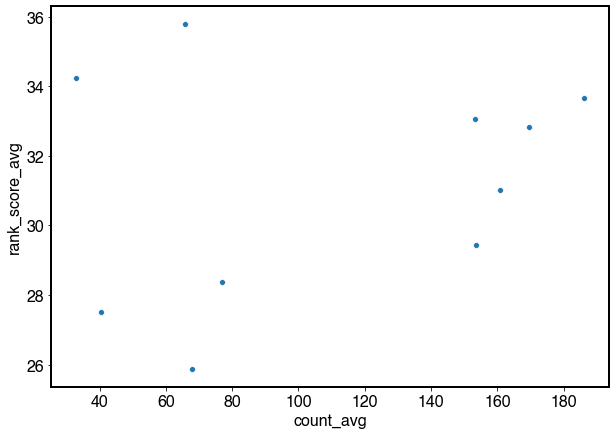

In [233]:
sns.scatterplot(x='count_avg', y='rank_score_avg', data=tmp)

In [150]:
tmp['category_avg'] = tmp.apply(
    lambda row: 'drug-specific' if (row[f'rank_score_avg'] >= 34 and row['count_avg'] < 50) 
    else 'pan-drug'
    if row['count_avg'] > 150 else 'other', axis=1)

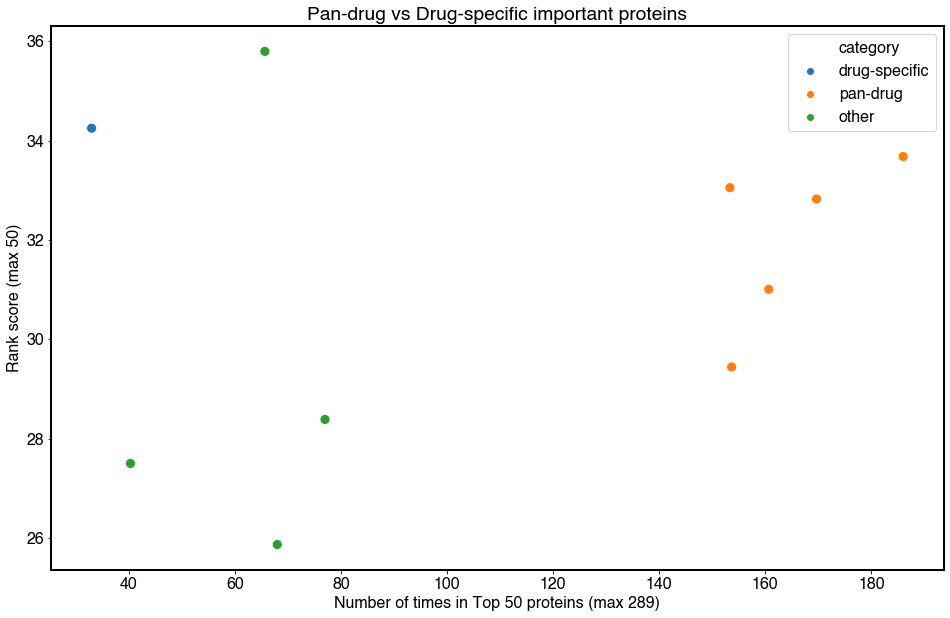

In [156]:
fig = plt.figure(figsize=(16, 10))
ax = sns.scatterplot(x='count_avg', y='rank_score_avg', hue='category_avg', data=tmp, s=100)
plt.xlabel("Number of times in Top 50 proteins (max 289)")
plt.ylabel("Rank score (max 50)")
plt.title("Pan-drug vs Drug-specific important proteins")
handles, labels = ax.get_legend_handles_labels()
labels[0] = 'category'
ax.legend(handles, labels)


plt.show()

In [152]:
tmp[tmp['category_avg']!='other'].sort_values([f'rank_score_avg'], ascending=False)

,protein,50-avg_rank_rf,count_rf,category_rf,50-avg_rank_en,count_en,category_en,50-avg_rank,count,category,count_avg,rank_score_avg,category_avg
0,PLAK_HUMAN,36.625000,24,other,34.920000,25,other,31.200000,50,other,33.000000,34.248333,drug-specific
5,LMNA_HUMAN,39.730159,252,pan-drug,37.739837,123,pan-drug,23.562842,183,other,186.000000,33.677613,pan-drug
1,COF2_HUMAN,33.407407,27,other,32.378378,74,other,33.364903,359,pan-drug,153.333333,33.050229,pan-drug
3,PTMA_HUMAN,26.949153,59,other,35.016667,60,other,36.502564,390,pan-drug,169.666667,32.822794,pan-drug
6,VTNC_HUMAN,24.378378,37,other,37.237805,164,pan-drug,31.398577,281,other,160.666667,31.004920,pan-drug
8,GDIR2_HUMAN,27.640449,89,other,26.032258,31,other,34.653959,341,other,153.666667,29.442222,pan-drug


### drug-specific

In [153]:
PLAK_drugs = set(shap_dict_drug['PLAK_HUMAN']).intersection(
    set(rf_dict_drug['PLAK_HUMAN'])).intersection(
        set(en_dict_drug['PLAK_HUMAN']))

In [155]:
for drug in PLAK_drugs:
    print(drug_name_map[drug])

Afatinib
Poziotinib
EGF816
PF-06747775
Ibrutinib
AZD8931
Sapatinib
Erlotinib
Gefitinib
Lapatinib


## rank vs count excluding tissue - no PC1

In [235]:
df_rf = pd.read_csv(
    "../../work_dirs/protein/RandomForest/feature_importance_202006061137_ruv_min_300_pc1_corrected.csv"
)
df_en = pd.read_csv(
    "../../work_dirs/protein/ElasticNet/feature_importance_202006071209_ruv_min_300_pc1_corrected.csv"
)
df_shap = pd.read_csv("../../result_files/shap/test_25_202006111047_pc1_corrected.csv")

In [236]:
drug_list = [1909, 1114, 1373, 1919, 1377, 119, 427, 1910, 1047]
drug_score = pd.read_csv("../../data/drug/final_drug_scores.tsv", sep="\t")
drug_list = drug_score[
    (drug_score['MultiDrug_correlation'] > 0.4) & (drug_score['sensitive_count'] > 20)][
    'drug_id'].values

In [237]:
drug_name_map = drug_score[[
    'drug_id', 'drug_name'
]].drop_duplicates().set_index('drug_id').to_dict()['drug_name']
drug_target_map = drug_score[[
    'drug_id', 'putative_gene_target'
]].drop_duplicates().set_index('drug_id').to_dict()['putative_gene_target']

### rf

In [238]:
topN = 50
rf_dict_count = {}
rf_dict_rank = {}
rf_dict_drug = {}
for drug in drug_list:
    rf_top_proteins = df_rf[['protein', f'importance_{drug}'
           ]].sort_values(by=[f'importance_{drug}'],
                          ascending=False).head(topN)['protein'].values
    rf_top_proteins = [x for x in rf_top_proteins if x not in shap_tissue_set]
    for i in range(len(rf_top_proteins)):
        if rf_top_proteins[i] not in rf_dict_count:
            rf_dict_count[rf_top_proteins[i]] = 0
            rf_dict_rank[rf_top_proteins[i]] = []
            rf_dict_drug[rf_top_proteins[i]] = []
            
        rf_dict_rank[rf_top_proteins[i]].append(i)
        rf_dict_count[rf_top_proteins[i]] += 1
        rf_dict_drug[rf_top_proteins[i]].append(drug)

In [239]:
rf_df = {'protein':[], f'{topN}-avg_rank':[], 'count':[]}
for p in rf_dict_rank:
    rf_dict_rank[p] = topN - np.average(rf_dict_rank[p])
    rf_df['protein'].append(p)
    rf_df[f'{topN}-avg_rank'].append(rf_dict_rank[p])
    rf_df['count'].append(rf_dict_count[p])
rf_df = pd.DataFrame(rf_df)

In [240]:
rf_df_filtered = rf_df[rf_df['count']+rf_df[f'{topN}-avg_rank'] > topN]

In [241]:
rf_df_filtered['category'] = rf_df_filtered.apply(
    lambda row: 'drug specific' if (row[f'{topN}-avg_rank'] > 48 and row['count'] < 50) 
    else 'pan-drug'
    if row['count'] > 80 else 'other', axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


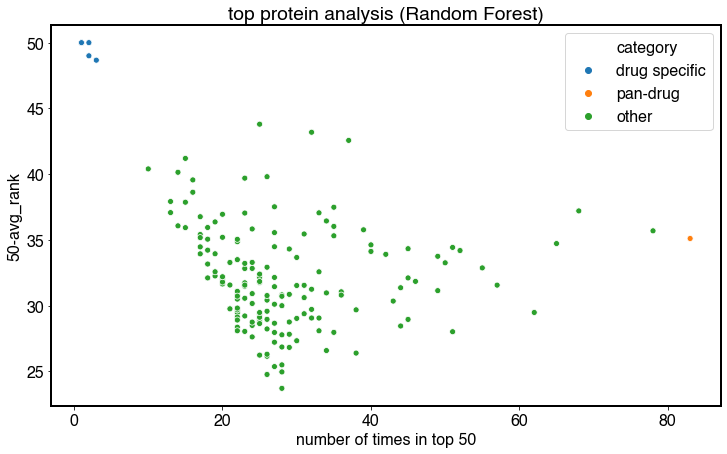

In [242]:
plt.figure(figsize=(12, 7))
g = sns.scatterplot(x='count',
                    y=f'{topN}-avg_rank',
                    hue='category',
                    hue_order=['drug specific', 'pan-drug', 'other'],
                    data=rf_df_filtered)
# for index, row in rf_df_filtered.iterrows():
#     if row['category'] != 'other':
#         g.annotate(row['protein'],
#                    xy=(row['count'], row[f'{topN}-avg_rank']),
#                    xycoords='data',
#                    xytext=(0, 20),
#                    textcoords='offset points',
#                    arrowprops=dict(arrowstyle="->"))
plt.xlabel(f'number of times in top {topN}')
plt.title("top protein analysis (Random Forest)")
plt.show()

In [243]:
rf_df_filtered[rf_df_filtered['category']!='other'].sort_values([f'{topN}-avg_rank'], ascending=False)

,protein,50-avg_rank,count,category
1897,DX39B_HUMAN,50.000000,1,drug specific
2009,ADK_HUMAN,50.000000,1,drug specific
2138,STX6_HUMAN,50.000000,2,drug specific
2307,ARGI2_HUMAN,50.000000,1,drug specific
2440,ENTP1_HUMAN,50.000000,1,drug specific
2733,SYYM_HUMAN,50.000000,1,drug specific
2828,NCOR2_HUMAN,50.000000,1,drug specific
2328,SCG1_HUMAN,49.000000,2,drug specific
1420,K22E_HUMAN,48.666667,3,drug specific
288,ITB1_HUMAN,35.108434,83,pan-drug


### ENet

In [244]:
topN = 50
en_dict_count = {}
en_dict_rank = {}
en_dict_drug = {}
for drug in drug_list:
    tmp = df_en[['protein', f'importance_{drug}']]
    tmp = tmp[tmp[f'importance_{drug}'] != 0]
    tmp['abs'] = np.abs(tmp[f'importance_{drug}'])
    en_top_proteins = tmp.sort_values(by=['abs'],
                        ascending=False)[['protein', f'importance_{drug}'
                                          ]].head(topN)['protein'].values
    en_top_proteins = [x for x in en_top_proteins if x not in shap_tissue_set]
    for i in range(len(en_top_proteins)):
        if en_top_proteins[i] not in en_dict_count:
            en_dict_count[en_top_proteins[i]] = 0
            en_dict_rank[en_top_proteins[i]] = []
            en_dict_drug[en_top_proteins[i]] = []
            
        en_dict_rank[en_top_proteins[i]].append(i)
        en_dict_count[en_top_proteins[i]] += 1
        en_dict_drug[en_top_proteins[i]].append(drug)

In [245]:
en_df = {'protein':[], f'{topN}-avg_rank':[], 'count':[]}
for p in en_dict_rank:
    en_dict_rank[p] = topN - np.average(en_dict_rank[p])
    en_df['protein'].append(p)
    en_df[f'{topN}-avg_rank'].append(en_dict_rank[p])
    en_df['count'].append(en_dict_count[p])
en_df = pd.DataFrame(en_df)

In [246]:
en_df_filtered = en_df[en_df['count']+en_df[f'{topN}-avg_rank'] > topN]

In [247]:
en_df_filtered['category'] = en_df_filtered.apply(
    lambda row: 'drug specific'
    if (row[f'{topN}-avg_rank'] > topN-2 and row['count'] < 100) 
    else 'pan-drug'if (row['count'] > 80 and row[f'{topN}-avg_rank'] > 10)
    else 'other',
    axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'top protein analysis (Elastic Net)')

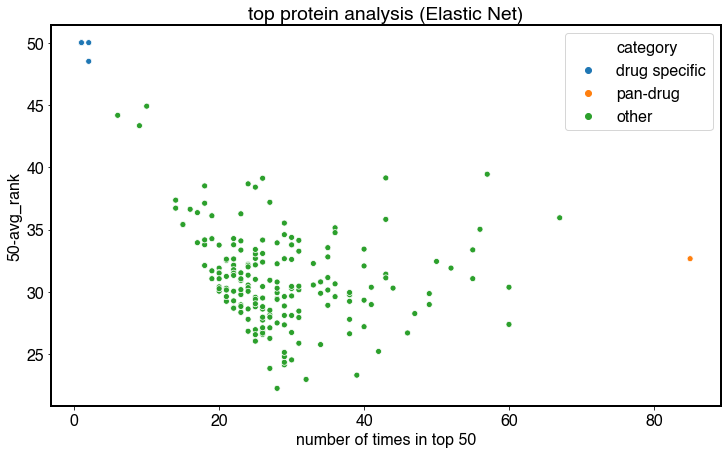

In [248]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x='count',
                y=f'{topN}-avg_rank',
                hue='category',
                hue_order=['drug specific', 'pan-drug', 'other'],
                data=en_df_filtered)
plt.xlabel(f'number of times in top {topN}')
plt.title("top protein analysis (Elastic Net)")

In [249]:
en_df_filtered[en_df_filtered['category']!='other'].sort_values([f'{topN}-avg_rank'], ascending=False)

,protein,50-avg_rank,count,category
100,PTPRF_HUMAN,50.000000,1,drug specific
500,TOP2A_HUMAN,50.000000,1,drug specific
915,IGHM_HUMAN,50.000000,1,drug specific
970,DEFI6_HUMAN,50.000000,1,drug specific
1631,MBB1A_HUMAN,50.000000,1,drug specific
1748,ENTP1_HUMAN,50.000000,2,drug specific
1959,FKBP2_HUMAN,50.000000,1,drug specific
1965,MECR_HUMAN,50.000000,1,drug specific
1364,CD3E_HUMAN,48.500000,2,drug specific
49,LEG1_HUMAN,32.658824,85,pan-drug


### shap

In [250]:
topN = 50
shap_dict_count = {}
shap_dict_rank = {}
shap_dict_drug = {}
for drug in drug_list:
    tmp = df_shap[['protein', f'importance_{drug}']]
    tmp = tmp[tmp[f'importance_{drug}'] != 0]
    tmp['abs'] = np.abs(tmp[f'importance_{drug}'])
    shap_top_proteins = tmp.sort_values(by=['abs'],
                        ascending=False)[['protein', f'importance_{drug}'
                                          ]].head(topN)['protein'].values
    shap_top_proteins = [x for x in shap_top_proteins if x not in shap_tissue_set]
    for i in range(len(shap_top_proteins)):
        if shap_top_proteins[i] not in shap_dict_count:
            shap_dict_count[shap_top_proteins[i]] = 0
            shap_dict_rank[shap_top_proteins[i]] = []
            shap_dict_drug[shap_top_proteins[i]] = []
            
        shap_dict_rank[shap_top_proteins[i]].append(i)
        shap_dict_count[shap_top_proteins[i]] += 1
        shap_dict_drug[shap_top_proteins[i]].append(drug)

In [251]:
shap_df = {'protein':[], f'{topN}-avg_rank':[], 'count':[]}
for p in shap_dict_rank:
    shap_dict_rank[p] = topN - np.average(shap_dict_rank[p])
    shap_df['protein'].append(p)
    shap_df[f'{topN}-avg_rank'].append(shap_dict_rank[p])
    shap_df['count'].append(shap_dict_count[p])
shap_df = pd.DataFrame(shap_df)

In [252]:
shap_df_filtered = shap_df[shap_df['count']+shap_df[f'{topN}-avg_rank'] > (topN-10)]

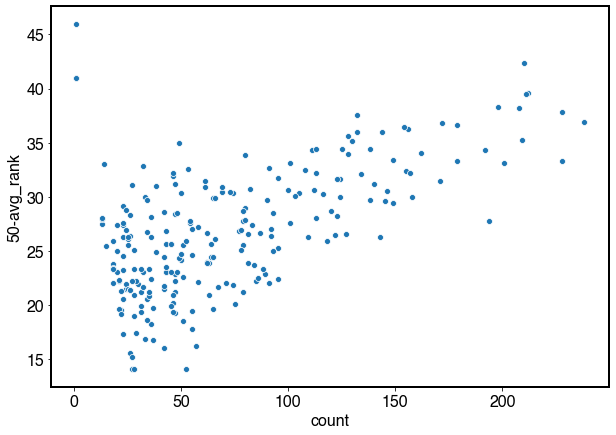

In [253]:
sns.scatterplot(x='count', y=f'{topN}-avg_rank', data=shap_df_filtered)

In [254]:
shap_df_filtered['category'] = shap_df_filtered.apply(
    lambda row: 'drug specific' if (row[f'{topN}-avg_rank'] >= 40 and row['count'] < 50) 
    else 'pan-drug'
    if row['count'] > 350 else 'other', axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'top protein analysis (MultiDrugNN)')

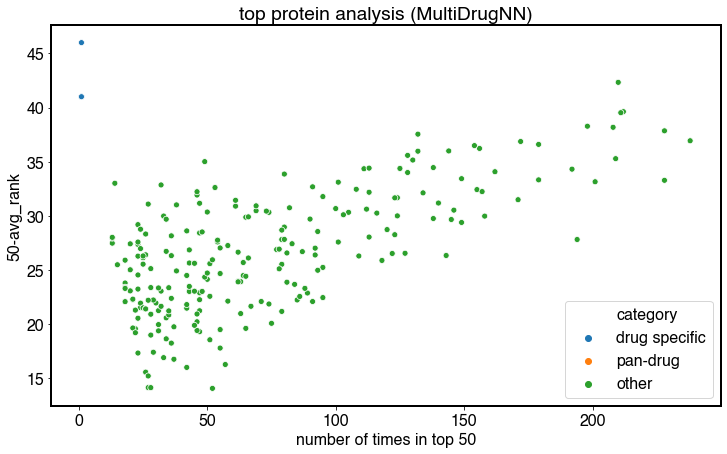

In [255]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x='count',
                y=f'{topN}-avg_rank',
                hue='category',
                hue_order=['drug specific', 'pan-drug', 'other'],
                data=shap_df_filtered)
plt.xlabel(f'number of times in top {topN}')
plt.title("top protein analysis (MultiDrugNN)")

In [256]:
shap_df_filtered[shap_df_filtered['category']!='other'].sort_values([f'{topN}-avg_rank'], ascending=False)

,protein,50-avg_rank,count,category
418,ADK_HUMAN,46.0,1,drug specific
581,HMGB3_HUMAN,41.0,1,drug specific
671,PLST_HUMAN,41.0,1,drug specific


### combined

In [257]:
tmp = pd.merge(rf_df_filtered, en_df_filtered, on=['protein'], suffixes=['_rf', '_en'])

In [258]:
tmp = pd.merge(tmp, shap_df_filtered, on=['protein'])

In [259]:
tmp['count_avg'] = tmp.apply(
    lambda row: np.average([row['count'], row['count_en'], row['count_rf']]), axis=1)
tmp['rank_score_avg'] = tmp.apply(lambda row: np.average([
    row['50-avg_rank'], row['50-avg_rank_en'], row['50-avg_rank_rf']]), axis=1)

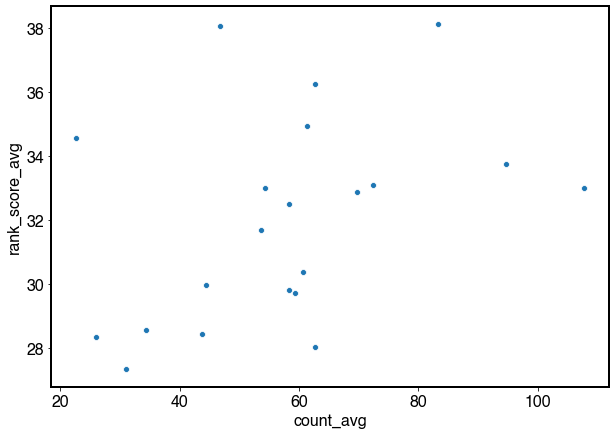

In [260]:
sns.scatterplot(x='count_avg', y='rank_score_avg', data=tmp)

In [261]:
tmp

,protein,50-avg_rank_rf,count_rf,category_rf,50-avg_rank_en,count_en,category_en,50-avg_rank,count,category,count_avg,rank_score_avg
0,PLAK_HUMAN,37.485714,35,other,35.138889,36,other,32.168142,113,other,61.333333,34.930915
1,SPY4_HUMAN,42.567568,37,other,39.438596,57,other,32.217391,46,other,46.666667,38.074518
2,VTNC_HUMAN,34.192308,52,other,35.940299,67,other,20.952381,63,other,60.666667,30.361662
3,TGM2_HUMAN,29.681818,22,other,31.418605,43,other,28.026549,113,other,59.333333,29.708991
4,S10AB_HUMAN,29.761905,21,other,30.433333,30,other,21.785714,42,other,31.000000,27.326984
5,GSTO1_HUMAN,33.666667,30,other,39.115385,26,other,35.962121,132,other,62.666667,36.248057
6,NAMPT_HUMAN,38.625000,16,other,36.260870,23,other,39.521327,211,other,83.333333,38.135732
7,PDLI7_HUMAN,31.561404,57,other,32.600000,30,other,35.146154,130,other,72.333333,33.102519
8,ITA3_HUMAN,32.872727,55,other,34.129032,31,other,31.650407,123,other,69.666667,32.884055
9,ANXA2_HUMAN,28.454545,44,other,29.611111,36,other,27.565217,23,other,34.333333,28.543625


In [150]:
tmp['category_avg'] = tmp.apply(
    lambda row: 'drug-specific' if (row[f'rank_score_avg'] >= 34 and row['count_avg'] < 50) 
    else 'pan-drug'
    if row['count_avg'] > 150 else 'other', axis=1)

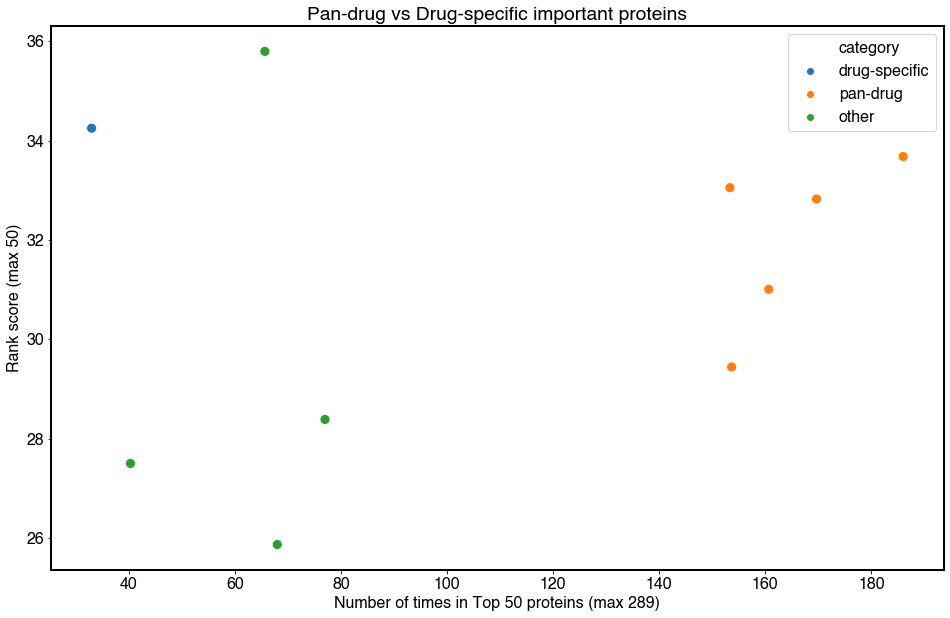

In [156]:
fig = plt.figure(figsize=(16, 10))
ax = sns.scatterplot(x='count_avg', y='rank_score_avg', hue='category_avg', data=tmp, s=100)
plt.xlabel("Number of times in Top 50 proteins (max 289)")
plt.ylabel("Rank score (max 50)")
plt.title("Pan-drug vs Drug-specific important proteins")
handles, labels = ax.get_legend_handles_labels()
labels[0] = 'category'
ax.legend(handles, labels)


plt.show()

In [152]:
tmp[tmp['category_avg']!='other'].sort_values([f'rank_score_avg'], ascending=False)

,protein,50-avg_rank_rf,count_rf,category_rf,50-avg_rank_en,count_en,category_en,50-avg_rank,count,category,count_avg,rank_score_avg,category_avg
0,PLAK_HUMAN,36.625000,24,other,34.920000,25,other,31.200000,50,other,33.000000,34.248333,drug-specific
5,LMNA_HUMAN,39.730159,252,pan-drug,37.739837,123,pan-drug,23.562842,183,other,186.000000,33.677613,pan-drug
1,COF2_HUMAN,33.407407,27,other,32.378378,74,other,33.364903,359,pan-drug,153.333333,33.050229,pan-drug
3,PTMA_HUMAN,26.949153,59,other,35.016667,60,other,36.502564,390,pan-drug,169.666667,32.822794,pan-drug
6,VTNC_HUMAN,24.378378,37,other,37.237805,164,pan-drug,31.398577,281,other,160.666667,31.004920,pan-drug
8,GDIR2_HUMAN,27.640449,89,other,26.032258,31,other,34.653959,341,other,153.666667,29.442222,pan-drug


### drug-specific

In [153]:
PLAK_drugs = set(shap_dict_drug['PLAK_HUMAN']).intersection(
    set(rf_dict_drug['PLAK_HUMAN'])).intersection(
        set(en_dict_drug['PLAK_HUMAN']))

In [155]:
for drug in PLAK_drugs:
    print(drug_name_map[drug])

Afatinib
Poziotinib
EGF816
PF-06747775
Ibrutinib
AZD8931
Sapatinib
Erlotinib
Gefitinib
Lapatinib


## specific drugs

In [327]:
name_map = pd.read_csv("../../data/misc/HUMAN_9606_idmapping.gene_prot.dat",
                       sep='\t',
                       names=['ID', 'type', 'code'])
name_map = name_map.drop_duplicates(['ID', 'type'])
name_map = pd.pivot(name_map, index='ID', columns='type', values='code').dropna()

name_map_dict = dict(zip(name_map['UniProtKB-ID'].values, name_map['Gene_Name'].values))

In [307]:
drug_id = 1029

In [321]:
topN = 50
top_proteins = []

In [324]:
df_en_drug = df_en[['protein',
                    f'importance_{drug_id}']].set_index('protein').sort_values(
                        by=f'importance_{drug_id}', ascending=False)
df_en_drug['abs'] = df_en_drug[f'importance_{drug_id}'].abs()
df_en_drug = df_en_drug.sort_values(by=['abs'], ascending=False).reset_index()
top_proteins.extend(df_en_drug['protein'].values[:topN])

In [331]:
df_en_drug.head(10)

,protein,importance_1029,abs
0,HMGN2_HUMAN,-0.136216,0.136216
1,PTMA_HUMAN,-0.120811,0.120811
2,VPS45_HUMAN,0.082640,0.082640
3,XRP2_HUMAN,0.077753,0.077753
4,HYPK_HUMAN,-0.076531,0.076531
5,RS15_HUMAN,-0.074425,0.074425
6,ZN622_HUMAN,0.071025,0.071025
7,PDCD6_HUMAN,0.070992,0.070992
8,BAF_HUMAN,0.069362,0.069362
9,RU2B_HUMAN,-0.067873,0.067873


In [325]:
df_rf_drug = df_rf[['protein',
                    f'importance_{drug_id}']].set_index('protein').sort_values(
                        by=f'importance_{drug_id}', ascending=False)
df_rf_drug['abs'] = df_rf_drug[f'importance_{drug_id}'].abs()
df_rf_drug = df_rf_drug.sort_values(by=['abs'], ascending=False).reset_index()
top_proteins.extend(df_rf_drug['protein'].values[:topN])

In [332]:
df_rf_drug.head(10)

,protein,importance_1029,abs
0,RU2B_HUMAN,0.009782,0.009782
1,SF3A2_HUMAN,0.009297,0.009297
2,RBM8A_HUMAN,0.008930,0.008930
3,HMGN2_HUMAN,0.004492,0.004492
4,BAF_HUMAN,0.003902,0.003902
5,RABL3_HUMAN,0.003770,0.003770
6,SNRPA_HUMAN,0.003519,0.003519
7,YBOX1_HUMAN,0.003370,0.003370
8,PDCD6_HUMAN,0.003232,0.003232
9,UBL5_HUMAN,0.003074,0.003074


In [328]:
top_proteins = set(top_proteins)
for x in top_proteins:
    print(name_map_dict[x] if x in name_map_dict else '')

PRCP
TPT1
RP2
ZNF622
MATR3
SSR3
UQCC2
KPNA4
NDUFS6
SCCPDH
HMGN1
SGPL1
LCP1
CSTF2T
RTN4
GDI2
ISCA2
CLNS1A
LARP7
HSPE1
CDC42BPB
CBX3
HNRNPM
NUP88
SNRPA
SF3A2
DMAC2L
HMGB2
GM2A
CENPB
RAB1A
PTRH2
ABCE1
DAP3
APBB1IP
PSMA5
IFI35
RFC3
MRM1
TRIM29
HMGN2
SNRPB2
KRT2
PAIP1
KPNA6
RBMX
HYPK
ANXA1
SNAP23
RBM8A
GNL3L
TMEM165
ANKHD1
PRPS1
STRN
VPS45
CEP170
BANF1
EIF3H
GNAO1
RABL3
GTF2B
CLCN7
CLPX
CPSF1
PDCD6
ELAC2
YME1L1
NFYB
YBX1
ZNF512
KHSRP
TEX264
CXorf56
PSAT1
RAP2B
CHRAC1
UBL5
RPS15
SYNCRIP
RBM3
RPS27A
NUDT5
SRSF5
PTMA
